This notebook is licensed under the MIT License. See the [LICENSE file](https://github.com/tommasocarraro/LTNtorch/blob/main/LICENSE) in the project root for details.

# Learning in LTN

This tutorial explains the concept of learning in Logic Tensor Networks.

In particular, it explains how to learn some language symbols (predicates, functions, constants) using the satisfaction
of a knowledge base as an objective.

For those unfamiliar with logic, a knowledge base is a container of logical formulas. Satisfying a knowledge base
as an objective means find a solution which maximize the satisfaction of all the formulas contained in the knowledge base.
In other words, we would find a representation for predicates, functions, and constants which increase the truth degree
of the formulas in the knowledge base.

This tutorial expects basic familiarity of the first two tutorials on LTN (grounding of symbols and connectives).

In [1]:
import torch
import numpy as np
import ltn
import matplotlib.pyplot as plt

## Classification with Nearest Neighbour

We use the following simple example to illustrate learning in LTN.

The domain is the square $[0,4] \times [0,4]$. We have some points in this domain, and we need to infer their classes.
In particular, we know the classes of only two examples. One example is of class $A$ and the other of class $B$.
The rest of the points are not labelled, but there are two assumptions:
- $A$ and $B$ are mutually exclusive,
- any two close points should share the same label.

In the following, we plot our dataset made of 19 points. We distinguish between classified and not classified examples.

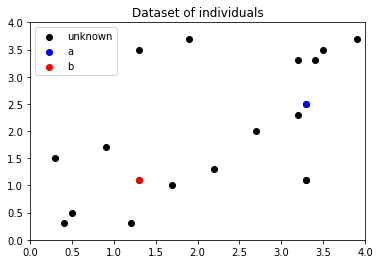

In [2]:
points = np.array(
        [[0.4,0.3], [1.2,0.3], [2.2,1.3], [1.7,1.0], [0.5,0.5], [0.3, 1.5], [1.3, 1.1], [0.9, 1.7],
        [3.4,3.3], [3.2,3.3], [3.2,2.3], [2.7,2.0], [3.5,3.5], [3.3, 2.5], [3.3, 1.1], [1.9, 3.7], [1.3, 3.5],
        [3.3, 1.1],[3.9, 3.7]])
point_a = [3.3, 2.5]
point_b = [1.3, 1.1]
fig, ax = plt.subplots()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.scatter(points[:,0], points[:,1], color="black", label="unknown")
ax.scatter(point_a[0], point_a[1], color="blue", label="a")
ax.scatter(point_b[0], point_b[1], color="red", label="b")
ax.set_title("Dataset of individuals")
plt.legend();

## Definition of knowledge base

First, we need to define a membership predicate $C(x,l)$, where $x$ is an individual (point) and $l$ is a one-hot label
denoting one of the two classes (10 for class $A$ and 01 for class $B$).

$C$ is approximated by a simple MLP (Multi-Layer Perceptron). The last layer, that computes probabilities per class, uses a `softmax` activation, ensuring that the classes are mutually-exclusive.

We define the knowledge base $\mathcal{K}$ with the following rules:
\begin{align}
& C(a,l_a)\\
& C(b,l_b)\\
\forall x_1,x_2,l\ \big(\mathrm{Sim}(x_1,x_2) & \rightarrow \big(C(x_1,l)\leftrightarrow C(x_2,l)\big)\big)
\end{align}

where:
- $a$ and $b$ the two individuals already classified;
- $x_1$ and $x_2$ are variables ranging over all individuals;
- $l_a$ and $l_b$ are the one-hot labels for $A$ and $B$;
- $l$ is a variable ranging over the labels;
- $\mathrm{Sim}$ is a predicate measuring similarity between two points and defined as $\mathcal{G}(\mathrm{Sim}):\vec{u},\vec{v}\mapsto \exp(-\|\vec{u}-\vec{v} \|^2)$.

The objective is to learn the predicate $C$ in such a way to maximize the satisfaction of $\mathcal{K}$.

If $\theta$ denotes the set of trainable parameters, the task is:
\begin{align}
\theta^\ast = \mathrm{argmax}_{\theta\in\Theta}\ \mathrm{SatAgg}_{\phi\in\mathcal{K}} \text{ } \mathcal{G}_{\theta}(\phi)
\end{align}

where $\mathrm{SatAgg}$ is an operator that aggregates the truth values of the formulas in $\mathcal{K}$
(if there are more than one formula).

In order to define the knowledge base in LTN, we need to define our predicates, variables, and constants first.

In the
following, the names of predicates, variables, and constants are the same used in the problem formulation above.

In [3]:
# Predicate C
class ModelC(torch.nn.Module):
    def __init__(self):
        super(ModelC, self).__init__()
        self.elu = torch.nn.ELU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.dense1 = torch.nn.Linear(2, 5)
        self.dense2 = torch.nn.Linear(5, 5)
        self.dense3 = torch.nn.Linear(5, 2)

    def forward(self, x, l):
        """x: point, l: one-hot label"""
        x = self.elu(self.dense1(x))
        x = self.elu(self.dense2(x))
        prob = self.softmax(self.dense3(x))
        return torch.sum(prob * l, dim=1)

C = ltn.Predicate(ModelC())

# Predicate Sim
Sim = ltn.Predicate(func=lambda u, v: torch.exp(-1. * torch.sqrt(torch.sum(torch.square(u - v), dim=1))))

In [4]:
# variables and constants
x1 = ltn.Variable("x1", torch.tensor(points))
x2 = ltn.Variable("x2", torch.tensor(points))
a = ltn.Constant(torch.tensor([3.3, 2.5]))
b = ltn.Constant(torch.tensor([1.3, 1.1]))
l_a = ltn.Constant(torch.tensor([1, 0]))
l_b = ltn.Constant(torch.tensor([0, 1]))
l = ltn.Variable("l", torch.tensor([[1, 0], [0, 1]]))

In the following, we plot the similarity of each point in the dataset with the point $a$. Lower the similarity, thinner the line
which connect the points.

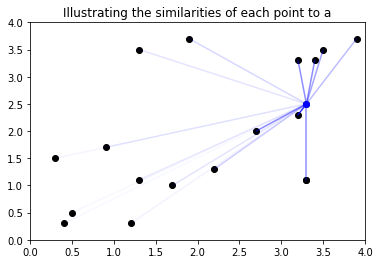

In [5]:
similarities_to_a = Sim(x1, a).value
fig, ax = plt.subplots()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.scatter(points[:,0], points[:,1], color="black")
ax.scatter(a.value[0], a.value[1], color="blue")
ax.set_title("Illustrating the similarities of each point to a")
for i, sim_to_a in enumerate(similarities_to_a):
    plt.plot([points[i,0], a.value[0]], [points[i,1],a.value[1]], alpha=float(sim_to_a.numpy()), color="blue")

For the connectives, we use the stable "product configuration" explained in the complementary notebook (2b-grounding-connectives.ipynb).

In particular, the operator for equivalence ($p \leftrightarrow q$) is implemented in LTN as $(p \rightarrow q)\land(q \rightarrow p)$, using
one operator for conjunction and one operator for implication. Such operator is available at `ltn.fuzzy_ops.Equiv`.

In [6]:
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach()))
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=6), quantifier="e")

Now that we have defined our predicates, variables, and constants, we are ready for defining the knowledge base.

If there are several closed formulas in $\mathcal{K}$, their truth values need to be aggregated, and this is what the $\mathrm{SatAgg}$
operator does. Currently, $\mathrm{SatAgg}$ supports only closed formulas.

To be clear, a closed formula is a formula which does not have free variables appearing in it,
namely all the variables are quantified.

In LTN, the $\mathrm{SatAgg}$ operator is available at `ltn.fuzzy_ops.SatAgg`. The constructor `SatAgg()` takes as input
an aggregation operator, which is then used to aggregate the inputs when the operator is invoked. Specifically, the operator takes as
input a list of truth values of closed formulas and returns the aggregation of these values using the selected aggregator.

As `SatAgg` aggregator, we recommend using the generalized mean inspired operator `pMeanError`, already used to implement $\forall$. For this reason, the constructor
`SatAgg()` defines the operator using the `pMeanError`.
The hyper-parameter $p$ again allows flexibility in how strict the formula aggregation is ($p = 1$ corresponds to `mean`; $p \to +\inf$ corresponds to `min`).

In the following, we define the `SatAgg` operator and a training loop to learn our LTN model.

As shown, the `SatAgg` operator takes as input the formulas in our knowledge base and returns a truth value which is
interpreted as the satisfaction level of the entire knowledge base. Since we want to maximize this number, we need to
minimize $1 - SatAgg$, using gradient descent.

Notice that it is not needed to access the `value` attribute before giving the formulas to the `SatAgg` operator. This is because
the operator accepts `LTNObject` instances in input.

In the forward phase of the LTN, the truth values of the three formulas are computed, while in the backward phase the weights
of predicate $C$ are changed in such a way to minimize the loss function.

In [7]:
# by default, SatAgg uses the pMeanError
sat_agg = ltn.fuzzy_ops.SatAgg()

# we need to learn the parameters of the predicate C
optimizer = torch.optim.Adam(C.parameters(), lr=0.001)

for epoch in range(2000):
    optimizer.zero_grad()
    loss = 1. - sat_agg(
        C(a, l_a),
        C(b, l_b),
        Forall([x1, x2, l], Implies(Sim(x1, x2), Equiv(C(x1, l), C(x2, l))))
    )
    loss.backward()
    optimizer.step()
    if epoch%200 == 0:
        print("Epoch %d: Sat Level %.3f "%(epoch, 1 - loss.item()))
print("Training finished at Epoch %d with Sat Level %.3f" %(epoch, 1 - loss.item()))

Epoch 0: Sat Level 0.604 
Epoch 200: Sat Level 0.787 
Epoch 400: Sat Level 0.942 
Epoch 600: Sat Level 0.956 
Epoch 800: Sat Level 0.958 
Epoch 1000: Sat Level 0.959 
Epoch 1200: Sat Level 0.959 
Epoch 1400: Sat Level 0.959 
Epoch 1600: Sat Level 0.959 
Epoch 1800: Sat Level 0.959 
Training finished at Epoch 1999 with Sat Level 0.959


After a few epochs, the system has learned to identify samples close to the point $a$ (resp. $b$) as belonging to class
$A$ (resp. $B$) based on the rules of the knowledge base.

In the following, we draw a plot showing that our LTN has been able to learn how to classify
the data points using the satisfaction of a knowledge base as an objective. The colour is brighter when predicate
$C$ is more satisfied. On the left, we see that $C$ correctly classifies points of class $A$, while on
the right we see it correctly classifies points of class $B$.

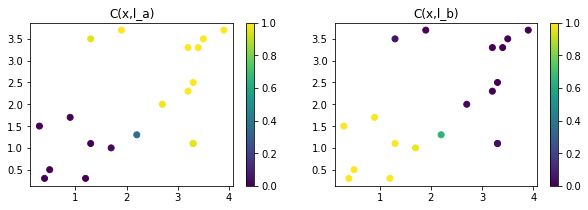

In [10]:
fig = plt.figure(figsize=(10, 3))
fig.add_subplot(1, 2, 1)
plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_a).value.detach().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_a)")
plt.colorbar()
fig.add_subplot(1, 2, 2)
plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_b).value.detach().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_b)")
plt.colorbar()
plt.show();

## Special Cases

### Variables grounded by batch

Usually, in the majority of learning tasks, we work with batches of data to make learning efficient.

In LTN, working with batches of data is straightforward. It is enough to ground the variables with different values
at each training step. In PyTorch, these values are usually returned by a `DataLoader`.

Let's see the same example with a bigger dataset (10000 points) which requires subdividing it in mini-batches.

In the following, we plot the dataset. The dataset has been randomly generated. Points $a$ and $b$ have been selected
in such a way they are enough distant between each other.

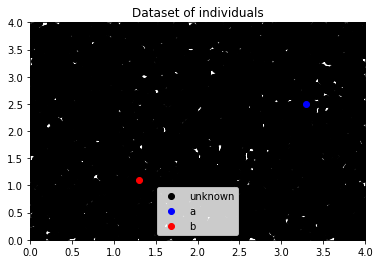

In [16]:
r1 = 0
r2 = 4
points = (r1 - r2) * torch.rand((10000, 2)) + r2
points[-1] = torch.tensor([3., 3.])
points[-2] = torch.tensor([1., 1.])
points_a = torch.tensor([3., 3.])
points_b = torch.tensor([1., 1.])
a = ltn.Constant(torch.tensor([3., 3.]))
b = ltn.Constant(torch.tensor([1., 1.]))

fig, ax = plt.subplots()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)
ax.scatter(points[:,0], points[:,1], color="black", label="unknown")
ax.scatter(point_a[0], point_a[1], color="blue", label="a")
ax.scatter(point_b[0], point_b[1], color="red", label="b")
ax.set_title("Dataset of individuals")
plt.legend();

In the following, we define a data loader which takes as input the entire dataset and returns batches of data points
fetched from the dataset. It is possible to decide a batch size and whether to shuffle data.

Then, as anticipated before, it is enough to add some lines of code that iterate over the batches and ground the variables
with the new data points contained in the batches.


In [17]:
# we define C again to re-initialize its weights
C = ltn.Predicate(ModelC())

# data loader which creates the batches
class DataLoader:
    def __init__(self,
                 dataset,
                 batch_size=1,
                 shuffle=True):
        self.data = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            batch_points = self.data[idxlist[start_idx:end_idx]]

            yield batch_points

train_loader = DataLoader(points, 512)

# by default, SatAgg uses the pMeanError
sat_agg = ltn.fuzzy_ops.SatAgg()

# we need to learn the parameters of the predicate C
optimizer = torch.optim.Adam(C.parameters(), lr=0.001)

for epoch in range(100):
    for (batch_idx, (batch_points)) in enumerate(train_loader):
        x1 = ltn.Variable("x1", batch_points)
        x2 = ltn.Variable("x2", batch_points)
        optimizer.zero_grad()
        loss = 1. - sat_agg(
            C(a, l_a),
            C(b, l_b),
            Forall([x1, x2, l], Implies(Sim(x1, x2), Equiv(C(x1, l), C(x2, l))))
        )
        loss.backward()
        optimizer.step()
    if epoch%10 == 0:
        print("Epoch %d: Sat Level %.3f "%(epoch, 1 - loss.item()))

print("Training finished at Epoch %d with Sat Level %.3f" %(epoch, 1 - loss.item()))

Epoch 0: Sat Level 0.580 
Epoch 10: Sat Level 0.890 
Epoch 20: Sat Level 0.948 
Epoch 30: Sat Level 0.953 
Epoch 40: Sat Level 0.950 
Epoch 50: Sat Level 0.945 
Epoch 60: Sat Level 0.943 
Epoch 70: Sat Level 0.949 
Epoch 80: Sat Level 0.947 
Epoch 90: Sat Level 0.947 
Training finished at Epoch 99 with Sat Level 0.945


It is possible to observe that just after 20 epochs, LTN has learned to correctly classify the examples.

Let's see some plot as we did for the previous example.

As shown, LTN has learned how to correctly classify the data points. Also, it is possible to observe that there are some points
in the middle which are more difficult to classify. This is intuitive since their distance from points $a$ and $b$ is similar, so LTN
does not know which is the correct class to assign to them.

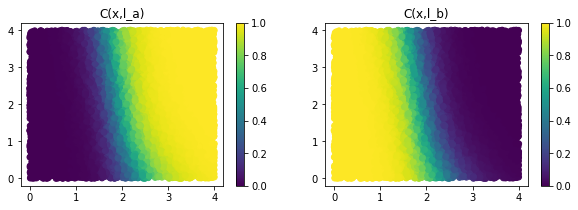

In [18]:
x1 = ltn.Variable("x1", points)
x2 = ltn.Variable("x2", points)
fig = plt.figure(figsize=(10, 3))
fig.add_subplot(1, 2, 1)
plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_a).value.detach().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_a)")
plt.colorbar()
fig.add_subplot(1, 2, 2)
plt.scatter(x1.value[:, 0], x1.value[:, 1], c=C(x1, l_b).value.detach().numpy(), vmin=0, vmax=1)
plt.title("C(x,l_b)")
plt.colorbar()
plt.show();